# Coursera
## Анализ данных: финальный проект
### Жёлтое такси в Нью-Йорке

## исходные данные:
* страница со ссылками: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page
* отдельные файлы:
    * за период с 2009-01 до 2019-06
        * https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2009-01.csv
        * ...
        * https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-06.csv
    
    * за период с 2019-07 до 2020-12
        * https://nyc-tlc.s3.amazonaws.com/trip+data/yellow_tripdata_2019-07.csv
        * ...
        * https://nyc-tlc.s3.amazonaws.com/trip+data/yellow_tripdata_2020-12.csv
    

In [1]:
# !pip install pandas
# !pip install fsspec
# !pip install matplotlib
# !pip install scipy
# !pip install basemap
# !pip install folium

In [2]:
import pandas as pd
from scipy import stats

from mpl_toolkits.basemap import Basemap

import folium
from folium.plugins import HeatMap

import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# вспомогательные функции
собраны в начало ноутбука, чтобы было удобнее перезапускать по частям

In [3]:
__nrows_full = None
__nrows_10 = 10_000

__nrows_week_01 = __nrows_full
# __nrows_week_01 = __nrows_10

__nrows_pipeline = __nrows_full
# __nrows_pipeline = __nrows_10

# __need_save=True
__need_save=False

__need_load=True
# __need_load=False

__need_save_2016_05_more_5=True
# __need_save_2016_05_more_5=False


In [4]:
__resolution='f'
# __resolution='l'


In [5]:
new_york_coords = {
    'west': -74.25559, 
    'east': -73.70001, 
    'north': 40.91553, 
    'south': 40.49612, 
}


In [6]:
empire_state_building_coords = {
    'longitude': -73.9857,
    'latitude': 40.7484,
}
# 1231;-73.9889116;-73.9778;40.747766;40.7561542

In [7]:
statue_of_liberty_coords = {
    'longitude': -74.0445,
    'latitude': 40.6892,
}


In [8]:
local_folder = '../data/'

## регионы

In [9]:
data_regions = pd.read_csv(local_folder + 'regions.csv', sep=';')
data_regions

,region,west,east,south,north
0,1,-74.255590,-74.244478,40.496120,40.504508
1,2,-74.255590,-74.244478,40.504508,40.512896
2,3,-74.255590,-74.244478,40.512896,40.521285
3,4,-74.255590,-74.244478,40.521285,40.529673
4,5,-74.255590,-74.244478,40.529673,40.538061
...,...,...,...,...,...
2495,2496,-73.711122,-73.700010,40.873589,40.881977
2496,2497,-73.711122,-73.700010,40.881977,40.890365
2497,2498,-73.711122,-73.700010,40.890365,40.898754
2498,2499,-73.711122,-73.700010,40.898754,40.907142


In [10]:
# data_regions['west'].value_counts()
# data_regions['east'].value_counts()
# data_regions['south'].value_counts()
# data_regions['north'].value_counts()

In [11]:
# data_regions['west'].unique()
# data_regions['east'].unique()
# data_regions['south'].unique()
# data_regions['north'].unique()

In [12]:
len(data_regions['west'].unique()), len(data_regions['east'].unique()), len(data_regions['south'].unique()), len(data_regions['north'].unique())

(50, 50, 50, 50)

In [13]:
set(data_regions['west'].unique()) - set(data_regions['east'].unique())

{-74.25559}

In [14]:
set(data_regions['south'].unique()) - set(data_regions['north'].unique())

{40.49612}

In [15]:
x_bins = data_regions['west'].append(data_regions['east']).unique()
y_bins = data_regions['south'].append(data_regions['north']).unique()

len(x_bins), len(y_bins)

(51, 51)

# неделя 02

## Загрузите агрегированные данные о поездках в мае 2016. Просуммируйте общее количество поездок такси из каждой географической зоны и посчитайте количество ячеек, из которых в мае не было совершено ни одной поездки.

In [16]:
if __need_load:
    data_result = pd.read_csv('result_2016_5.csv', parse_dates=['tpep_pickup_datetime'])
else:
    data_result = result_2016_5
    
data_result

,tpep_pickup_datetime,region,count
0,2016-05-01 00:00:00,1,0.0
1,2016-05-01 00:00:00,2,0.0
2,2016-05-01 00:00:00,3,0.0
3,2016-05-01 00:00:00,4,0.0
4,2016-05-01 00:00:00,5,0.0
...,...,...,...
1859995,2016-05-31 23:00:00,2496,0.0
1859996,2016-05-31 23:00:00,2497,0.0
1859997,2016-05-31 23:00:00,2498,0.0
1859998,2016-05-31 23:00:00,2499,0.0


In [17]:
len(data_result[data_result['count'] == 0.0])

1718238

In [18]:
data_result[data_result['count'] > 0]

,tpep_pickup_datetime,region,count
1014,2016-05-01 00:00:00,1015,1.0
1016,2016-05-01 00:00:00,1017,1.0
1028,2016-05-01 00:00:00,1029,3.0
1029,2016-05-01 00:00:00,1030,1.0
1032,2016-05-01 00:00:00,1033,4.0
...,...,...,...
1859568,2016-05-31 23:00:00,2069,17.0
1859569,2016-05-31 23:00:00,2070,1.0
1859617,2016-05-31 23:00:00,2118,192.0
1859618,2016-05-31 23:00:00,2119,77.0


In [19]:
data_result['count'].sum()

11626521.0

In [20]:
data_sum = data_result.groupby(by=['region']).sum().reset_index()[['region', 'count']]
data_sum

,region,count
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0
...,...,...
2495,2496,0.0
2496,2497,0.0
2497,2498,0.0
2498,2499,0.0


In [21]:
data_sum['count'].sum()

11626521.0

In [22]:
data_sum[data_sum['count'] > 0]

,region,count
14,15,1.0
15,16,1.0
24,25,1.0
26,27,1.0
31,32,19.0
...,...,...
2482,2483,2.0
2483,2484,1.0
2484,2485,2.0
2485,2486,3.0


<AxesSubplot:>

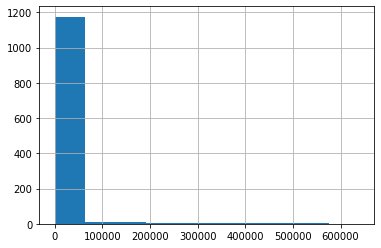

In [23]:
data_sum[data_sum['count'] > 0]['count'].hist()

In [24]:
len(data_sum[data_sum['count'] == 0])

1283

### Ответ:
1283

## Нарисуйте статическую карту Нью-Йорка. Поставьте на карте точку там, где находится Эмпайр-Стейт-Билдинг.

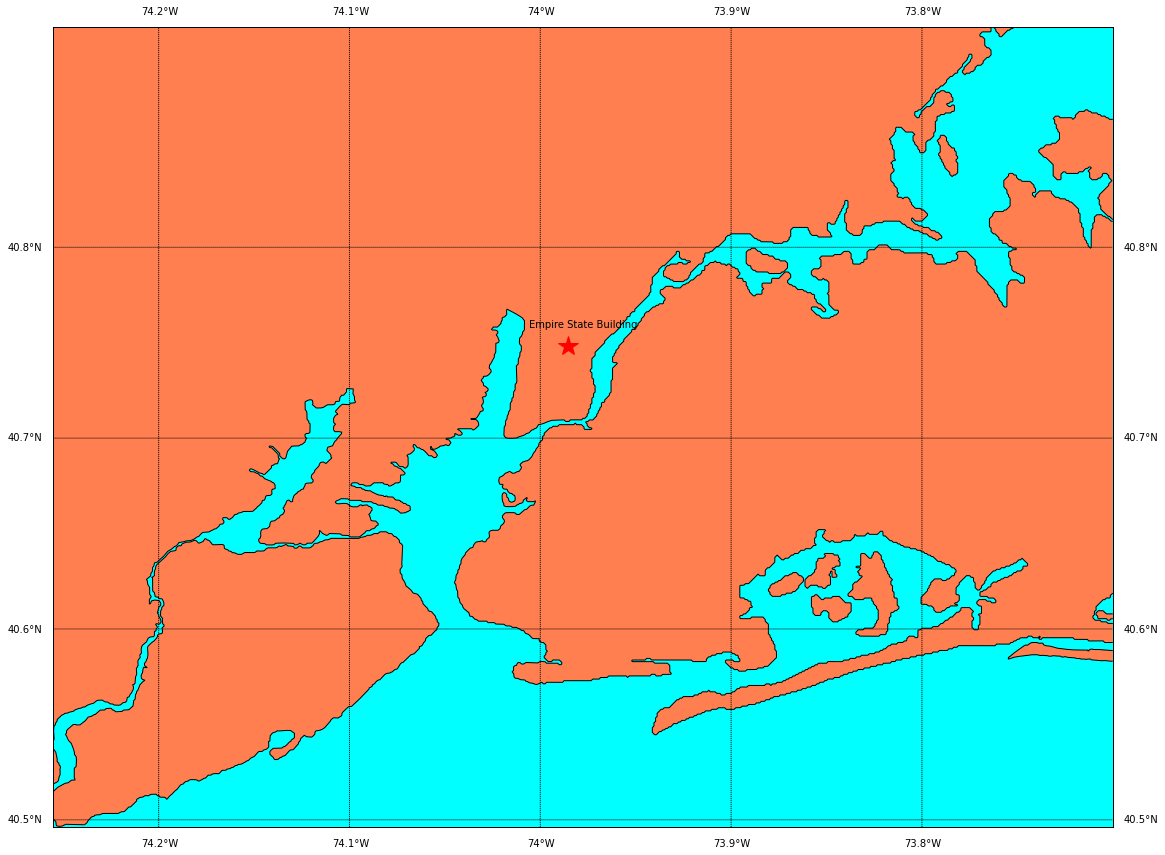

In [25]:
# fig, ax = plt.subplots(1, 1, figsize=(19, 19))

# m = Basemap(
#     llcrnrlon=new_york_coords['west'],
#     llcrnrlat=new_york_coords['south'],
#     urcrnrlon=new_york_coords['east'],
#     urcrnrlat=new_york_coords['north'],
#     resolution=__resolution,
#     ax=ax,
# )

# m.drawcoastlines()
# m.drawmapboundary(fill_color='aqua')
# m.fillcontinents(color='coral',lake_color='aqua')

# parallels = np.arange(40.5, 40.9, .1)
# # labels = [left,right,top,bottom]
# m.drawparallels(parallels,labels=[True,True,False,False])
# meridians = np.arange(-74.2, -73.7, .1)
# m.drawmeridians(meridians,labels=[False,False,True,True])

# x, y = m(empire_state_building_coords['longitude'], empire_state_building_coords['latitude'])
# m.plot(x, y, marker='*', color='r', markersize=20)
# plt.annotate('Empire State Building', xy=(x-0.02, y+0.01))

# plt.show()

## Поверх статической карты Нью-Йорка визуализируйте данные о поездках из каждой ячейки так, чтобы цветовая шкала, в которую вы окрашиваете каждую ячейку, показывала суммарное количество поездок такси из неё.

In [26]:
x_region = []
y_region = []
c_region = []

for n_region, count in data_sum.values:
    if count > 0:
        c_region.append(count)

        region_i = data_regions[data_regions['region'] == n_region]
        x_region.append((region_i['west'] + region_i['east']) / 2)
        y_region.append((region_i['south'] + region_i['north']) / 2)
    
x_region[:5], y_region[:5], c_region[:5]

([14   -74.250034
  dtype: float64,
  15   -74.250034
  dtype: float64,
  24   -74.250034
  dtype: float64,
  26   -74.250034
  dtype: float64,
  31   -74.250034
  dtype: float64],
 [14    40.617749
  dtype: float64,
  15    40.626137
  dtype: float64,
  24    40.701631
  dtype: float64,
  26    40.718407
  dtype: float64,
  31    40.760348
  dtype: float64],
 [1.0, 1.0, 1.0, 1.0, 19.0])

Text(-74.00569999999999, 40.758399999999995, 'Empire State Building')

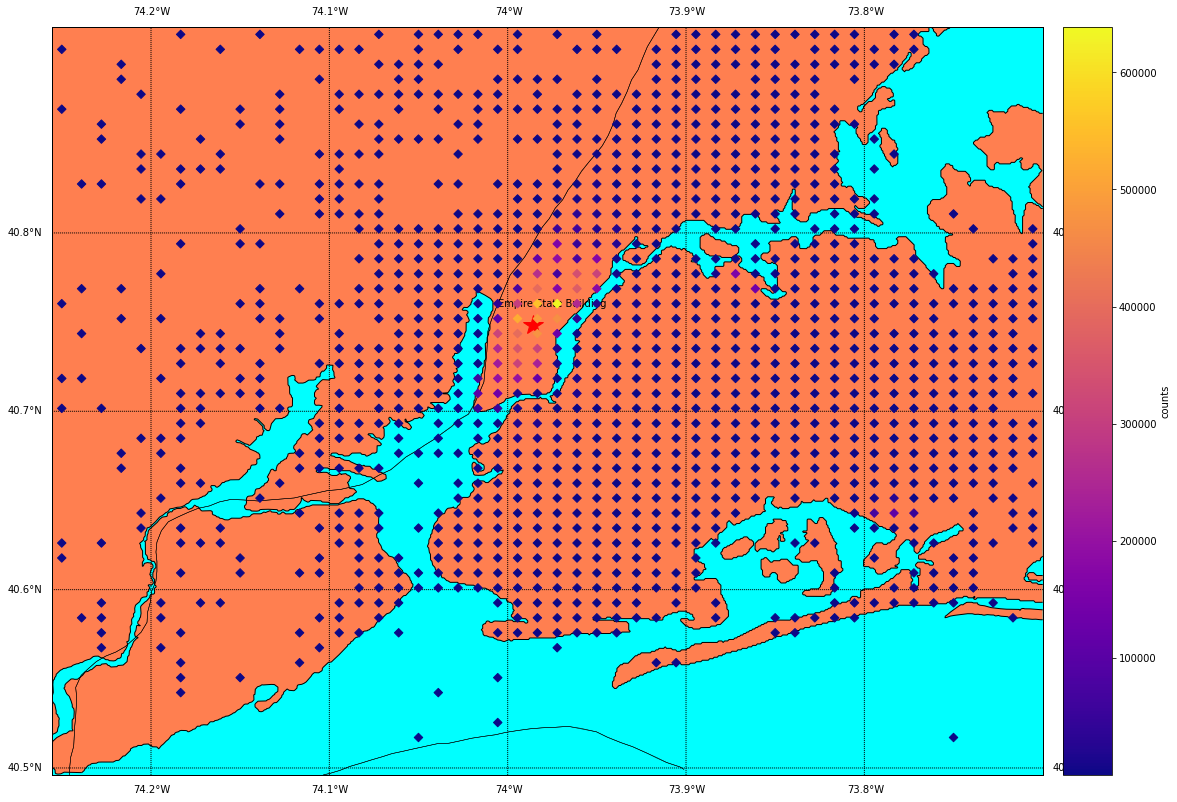

In [27]:
# fig, ax = plt.subplots(1, 1, figsize=(19, 19))

# m = Basemap(
#     llcrnrlon=new_york_coords['west'],
#     llcrnrlat=new_york_coords['south'],
#     urcrnrlon=new_york_coords['east'],
#     urcrnrlat=new_york_coords['north'],
#     resolution=__resolution,
#     ax=ax,
# )

# m.drawcoastlines()
# m.drawrivers()
# m.drawstates()
# m.drawmapboundary(fill_color='aqua')
# m.fillcontinents(color='coral',lake_color='aqua')

# x_map, y_map = m(x_region, y_region)
# obj = m.scatter(x_map, y_map, marker='D',
#                 c=c_region,
#                 zorder=10,
#                 cmap='plasma',
#                )

# cb = m.colorbar(obj, ax=ax)
# cb.set_label('counts')

# parallels = np.arange(40.5, 40.9, .1)
# # labels = [left,right,top,bottom]
# m.drawparallels(parallels,labels=[True,True,False,False])
# meridians = np.arange(-74.2, -73.7, .1)
# m.drawmeridians(meridians,labels=[False,False,True,True])

# x, y = m(empire_state_building_coords['longitude'], empire_state_building_coords['latitude'])
# m.plot(x, y, marker='*', color='r', markersize=20)
# plt.annotate('Empire State Building', xy=(x-0.02, y+0.01))


# Вставьте интерактивную карту Нью-Йорка — такую, которую можно прокручивать и увеличивать. Поставьте метку там, где находится статуя свободы.

In [28]:
statue_of_liberty_coords

{'longitude': -74.0445, 'latitude': 40.6892}

In [29]:
m = folium.Map(location=[(new_york_coords['south'] + new_york_coords['north']) / 2, (new_york_coords['west'] + new_york_coords['east']) / 2], 
               zoom_start=11
              )

tooltip = "Statue of Liberty" 

folium.Marker(
    [statue_of_liberty_coords['latitude'], statue_of_liberty_coords['longitude']], popup="<i>Statue of Liberty</i>", tooltip=tooltip, icon=folium.Icon(color="green", icon="info-sign")
).add_to(m)

m

## Нарисуйте на интерактивной карте Нью-Йорка ячейки так, чтобы их цвет показывал среднее за месяц количество поездок такси в час из этой зоны.

In [30]:
data_result

,tpep_pickup_datetime,region,count
0,2016-05-01 00:00:00,1,0.0
1,2016-05-01 00:00:00,2,0.0
2,2016-05-01 00:00:00,3,0.0
3,2016-05-01 00:00:00,4,0.0
4,2016-05-01 00:00:00,5,0.0
...,...,...,...
1859995,2016-05-31 23:00:00,2496,0.0
1859996,2016-05-31 23:00:00,2497,0.0
1859997,2016-05-31 23:00:00,2498,0.0
1859998,2016-05-31 23:00:00,2499,0.0


In [31]:
data_result['month'] = data_result['tpep_pickup_datetime'].dt.to_period('M')
data_result

,tpep_pickup_datetime,region,count,month
0,2016-05-01 00:00:00,1,0.0,2016-05
1,2016-05-01 00:00:00,2,0.0,2016-05
2,2016-05-01 00:00:00,3,0.0,2016-05
3,2016-05-01 00:00:00,4,0.0,2016-05
4,2016-05-01 00:00:00,5,0.0,2016-05
...,...,...,...,...
1859995,2016-05-31 23:00:00,2496,0.0,2016-05
1859996,2016-05-31 23:00:00,2497,0.0,2016-05
1859997,2016-05-31 23:00:00,2498,0.0,2016-05
1859998,2016-05-31 23:00:00,2499,0.0,2016-05


In [32]:
data_result[data_result['count'] > 0]

,tpep_pickup_datetime,region,count,month
1014,2016-05-01 00:00:00,1015,1.0,2016-05
1016,2016-05-01 00:00:00,1017,1.0,2016-05
1028,2016-05-01 00:00:00,1029,3.0,2016-05
1029,2016-05-01 00:00:00,1030,1.0,2016-05
1032,2016-05-01 00:00:00,1033,4.0,2016-05
...,...,...,...,...
1859568,2016-05-31 23:00:00,2069,17.0,2016-05
1859569,2016-05-31 23:00:00,2070,1.0,2016-05
1859617,2016-05-31 23:00:00,2118,192.0,2016-05
1859618,2016-05-31 23:00:00,2119,77.0,2016-05


In [33]:
len(data_result[data_result['count'] == 0.0])

1718238

In [34]:
data_mean = data_result.groupby(by=['region', 'month']).mean().reset_index()
data_mean

,region,month,count
0,1,2016-05,0.0
1,2,2016-05,0.0
2,3,2016-05,0.0
3,4,2016-05,0.0
4,5,2016-05,0.0
...,...,...,...
2495,2496,2016-05,0.0
2496,2497,2016-05,0.0
2497,2498,2016-05,0.0
2498,2499,2016-05,0.0


## Чтобы не выбирать из всех 2500 ячеек вручную, отфильтруйте ячейки, из которых в мае совершается в среднем меньше 5 поездок в час. Посчитайте количество оставшихся. Проверьте на карте, что среди этих ячеек нет таких, из которых поездки на самом деле невозможны.

In [35]:
data_mean[data_mean['count'] >= 5]

,region,month,count
1074,1075,2016-05,66.799731
1075,1076,2016-05,138.266129
1076,1077,2016-05,86.802419
1124,1125,2016-05,66.041667
1125,1126,2016-05,181.892473
...,...,...,...
2067,2068,2016-05,95.056452
2068,2069,2016-05,10.545699
2117,2118,2016-05,146.490591
2118,2119,2016-05,34.692204


In [36]:
if __need_save_2016_05_more_5:
    data_mean[data_mean['count'] >= 5].to_csv(f'data_2016_05_more_5.csv', index=False)

In [51]:
data = []
polygon_regions_all = []

for n_region, month, count in data_mean.values:
    if count >= 5:
#     if count >= -999999:
        c_region = count

        region_i = data_regions[data_regions['region'] == n_region]
        x_region = (region_i['west'] + region_i['east']) / 2
        y_region = (region_i['south'] + region_i['north']) / 2

#         data.append([y_region.values[0], x_region.values[0], c_region])
        data.append([y_region.values[0], x_region.values[0], c_region, n_region])
        
        polygon_regions_all.append(
            [
                (region_i['north'].values[0], region_i['west'].values[0]), 
                (region_i['north'].values[0], region_i['east'].values[0]), 
                (region_i['south'].values[0], region_i['east'].values[0]), 
                (region_i['south'].values[0], region_i['west'].values[0]), 
                (region_i['north'].values[0], region_i['west'].values[0]), 
            ],
        )
        
data[:5]

[[40.7016309, -74.0166906, 66.7997311827957, 1075],
 [40.7100191, -74.0166906, 138.26612903225808, 1076],
 [40.7184073, -74.0166906, 86.8024193548387, 1077],
 [40.7016309, -74.005579, 66.04166666666667, 1125],
 [40.7100191, -74.005579, 181.89247311827958, 1126]]

In [50]:
len(data)

102

### Ответ:
* 102
* визуально невозможными выглядят 2 ячейки, находящиеся на взлетно-посадочных полосах аэропортов

In [55]:
m = folium.Map(location=[(new_york_coords['south'] + new_york_coords['north']) / 2, (new_york_coords['west'] + new_york_coords['east']) / 2], 
               zoom_start=11
              )

tooltip = "Statue of Liberty" 

folium.Marker(
    [statue_of_liberty_coords['latitude'], statue_of_liberty_coords['longitude']], popup="<i>Statue of Liberty</i>", tooltip=tooltip, icon=folium.Icon(color="green", icon="info-sign")
).add_to(m)

data = np.array(data)

HeatMap(data[:, 0:3]).add_to(m)

for polugon_i, polygon_region in enumerate(polygon_regions_all):
    folium.PolyLine(polygon_region, color='black', weight=0.2).add_to(m)
    
#     y_region, x_region, c_region, n_region = data[polugon_i]
#     folium.Marker(
#         [y_region, x_region], popup=f"<i>{n_region}</i>", tooltip=f"<i>{n_region}</i>", 
#     ).add_to(m)

m
